In [ ]:
!pip install pymorphy2
!pip install pymystem3
!pip install gensim
!pip install -U featuretools

Импортируем библиотеки:

In [ ]:
from google.colab import files
import os
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
import re
import gensim
import logging
import nltk.data
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import word2vec

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')
import featuretools

Лемматизируем текст и записываем его в новый файл:

In [ ]:
morph = MorphAnalyzer()
m = Mystem()


2021-09-24 11:46:51,989 : INFO : Loading dictionaries from /usr/local/lib/python3.7/dist-packages/pymorphy2_dicts_ru/data
2021-09-24 11:46:52,040 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:


def cleanse(text):
    exclude = ",{}*%<>@—:;\"\'()[]+=^~—`123456789-«»0!?.\xa0\t"
    no_orpho = [symb for symb in text if not symb in exclude]
    return "".join(no_orpho) #возвращает почищенный массив строк

def lemmatize():
    src = ""
    with open("tolstoy_data.txt", "r+", encoding="utf-8") as f:
        src =  cleanse(f.read().lower())
    lemmas = [sentence for sentence in " ".join(m.lemmatize(src)).split("\n") if len(sentence) > 1]
    with open("tolstoy_out.txt", "w+", encoding="utf-8") as f:
        f.write("\n".join(lemmas))
    return src

lemmatize()

2021-09-24 11:46:43,659 : INFO : Loading dictionaries from /usr/local/lib/python3.7/dist-packages/pymorphy2_dicts_ru/data
2021-09-24 11:46:43,723 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


KeyboardInterrupt: ignored

В качестве источника я использую небольшую коллекцию рассказов Владимира Набокова.

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:

f = 'nabokov_out.txt'
data = gensim.models.word2vec.LineSentence(f)

При слишком большом значении параметра window модель считает схожими слова вообще разных категорий (например, прилагательное или предлог). Поэтому я поставил ему значение 5, которое, по моим ощущениям, неплохо работает.
Изменение параметра size как будто существенно ничего не меняет -- но при размере вектора в 600 результаты как будто лучше соответствуют моим интуициям.
Помимо этого, я увеличил количество эпох, чтобы модель лучше тренировалась, а также поставил порог частотности на значение 6, чтобы совсем редкие слова не портили картину. Минимальную частотность я поставил на 1, т.к. в моем корпусе и без того мало токенов.

In [ ]:
%time model_n = gensim.models.Word2Vec(data, size=600, window=5, min_count=1, iter = 30)

2021-09-24 10:17:33,302 : INFO : collecting all words and their counts
2021-09-24 10:17:33,306 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-09-24 10:17:33,363 : INFO : collected 12369 word types from a corpus of 109661 raw words and 2451 sentences
2021-09-24 10:17:33,365 : INFO : Loading a fresh vocabulary
2021-09-24 10:17:33,393 : INFO : effective_min_count=1 retains 12369 unique words (100% of original 12369, drops 0)
2021-09-24 10:17:33,395 : INFO : effective_min_count=1 leaves 109661 word corpus (100% of original 109661, drops 0)
2021-09-24 10:17:33,436 : INFO : deleting the raw counts dictionary of 12369 items
2021-09-24 10:17:33,438 : INFO : sample=0.001 downsamples 41 most-common words
2021-09-24 10:17:33,440 : INFO : downsampling leaves estimated 92038 word corpus (83.9% of prior 109661)
2021-09-24 10:17:33,481 : INFO : estimated required memory for 12369 words and 600 dimensions: 65555700 bytes
2021-09-24 10:17:33,484 : INFO : resetting layer

CPU times: user 25.9 s, sys: 318 ms, total: 26.2 s
Wall time: 16 s


In [ ]:
model_n.init_sims(replace=True)
model_path = "nabokov.bin"

print("Saving model...")
model_n.wv.save_word2vec_format(model_path, binary=True)

2021-09-24 10:17:51,917 : INFO : precomputing L2-norms of word weight vectors
2021-09-24 10:17:52,066 : INFO : storing 12369x600 projection weights into nabokov.bin


Saving model...


In [ ]:

print(len(model_n.wv.vocab))

2040


In [ ]:
print(sorted([w for w in model_n.wv.vocab]))

['a', 'ad', 'affaire', 'alors', 'automne', 'battez', 'caroche', 'delphini', 'dort', 'dмолль', 'ein', 'es', 'est', 'fr', 'i', 'ii', 'iii', 'il', 'incognita', 'iv', 'l', 'luinesco', 'mademoiselle', 'me', 'messt', 'mirifica', 'n', 'piombo', 'pocajou', 'polaris', 'polonais', 'priatequi', 'priori', 'prodlenie', 'ps', 'punchingball', 'que', 'qui', 'rompez', 'schriftsteller', 'sichasse', 'skandale', 'soglassen', 'souvenir', 't', 'terra', 'toute', 'une', 'usum', 'v', 'valieria', 'veuxtu', 'votte', 'was', 'x', 'xя', 'а', 'абажур', 'аббатство', 'абориген', 'абрикосовый', 'абсолютно', 'абсолютный', 'аванложа', 'август', 'августовский', 'авиация', 'авось', 'авт', 'автобиография', 'автобус', 'автомат', 'автомобиль', 'автомобильный', 'автор', 'ага', 'агрикур', 'ад', 'адвокат', 'адлоно', 'адмиралтейский', 'адольф', 'адрес', 'адресный', 'азартный', 'аильин', 'айда', 'айне', 'айяяй', 'акация', 'акварель', 'акварельный', 'аквариум', 'аккорд', 'аккордеон', 'аккуратно', 'аккуратный', 'акреан', 'акреанов',

In [ ]:
model_n.wv.most_similar(positive=["сон"], topn=5)

[('мир', 0.9410699605941772),
 ('некоторый', 0.9291661381721497),
 ('время', 0.9192520380020142),
 ('нетребовательный', 0.9189108610153198),
 ('чудиться', 0.9185394048690796)]

In [ ]:
model_n.wv.most_similar(positive=["идти"], topn=5)

[('двинуться', 0.7961381673812866),
 ('отвертываться', 0.7796123027801514),
 ('слоняться', 0.7717770338058472),
 ('далеко', 0.7599917054176331),
 ('лестница', 0.7451915144920349)]

In [ ]:
model_n.wv.most_similar(positive=["белый"], topn=5)

[('платье', 0.9817730784416199),
 ('серый', 0.9812049269676208),
 ('фонарь', 0.9804177284240723),
 ('ущемлять', 0.976550817489624),
 ('дробиться', 0.9705729484558105)]

In [ ]:

model_n.wv.most_similar("ты", topn=3)

[('я', 0.999983549118042),
 ('…', 0.9999815821647644),
 ('вы', 0.9999814629554749)]

In [ ]:
model_n.wv.doesnt_match("ты он она они".split())

'ты'

Построим график. Я выбрал ряд слов 'красный', 'синий', 'зеленый','злой' -- здесь очевидно, что цвета должны образовывать отдельную группу от прилагательного оценки. Так и происходит. 




In [ ]:
words = ['красный', 'синий', 'зеленый','злой']
X = model_n[words]

In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

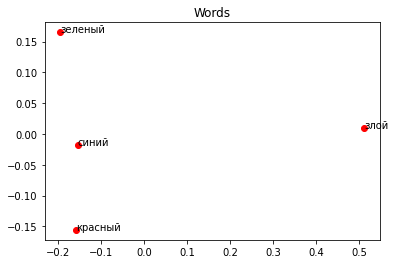

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

In [ ]:
urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", "ruscorpora_mystem_cbow_300_2_2015.bin.gz")
m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

if m.endswith('.vec.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=False)
elif m.endswith('.bin.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
else:
    model = gensim.models.KeyedVectors.load(m)

2021-09-23 22:23:47,225 : INFO : loading projection weights from ruscorpora_mystem_cbow_300_2_2015.bin.gz
2021-09-23 22:24:01,613 : INFO : loaded (281776, 300) matrix from ruscorpora_mystem_cbow_300_2_2015.bin.gz
